Some useful links:
* [ACM DEBS 2015 Grand Challenge](http://www.debs2015.org/call-grand-challenge.html)

* [Spark web site](https://spark.apache.org/)

* [Anonymity_api](https://github.com/farosilva0/anonymity_api)

* [IBM differential privacy library](https://github.com/IBM/differential-privacy-library)


# Install software

In [ ]:
# Install Spark
!apt-get install openjdk-17-jdk-headless
!pip install pyspark==4.0.0.dev2
!mkdir checkpoint


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  openjdk-17-jre-headless
Suggested packages:
  openjdk-17-demo openjdk-17-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  | fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-17-jdk-headless openjdk-17-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 34 not upgraded.
Need to get 120 MB of archives.
After this operation, 272 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 openjdk-17-jre-headless amd64 17.0.15+6~us1-0ubuntu1~22.04 [48.3 MB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 openjdk-17-jdk-headless amd64 17.0.15+6~us1-0ubuntu1~22.04 [71.3 MB]
Fetched 120 MB in 8s (14.3 MB/s)
Selecting previously unselected package openjdk-17-jre-headless:amd64.
(Re

In [ ]:
!pip install anonymity-api==1.0.4
!pip install diffprivlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.9/176.9 kB 3.6 MB/s eta 0:00:00


# Setup

The data sets are available in the following link: https://drive.google.com/drive/folders/1WMwLUj0t4Q0GSll96lbF2bDjaPVh1w8z?usp=sharing. For running in Google Colab, you should access the link and Add Shortcut to your Drive.



In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


!ls /content/drive/MyDrive/assignment1/


Mounted at /content/drive
adult.csv  Life_Expectancy_Data.csv  sample.csv.gz    sorted_data.csv.gz
heart.csv  sample.csv		     sorted_data.csv  tiny.csv.gz


In [ ]:
# Run this cell only if you are going to run exercise 1
# !mkdir data
# !cp /content/drive/MyDrive/assignment1/sample.csv data

Next cells setup: Pandas and Spark.

In [ ]:
# General imports
import timeit

import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.cluster

from anonymity_api import anonymity
from anonymity_api import utility

In [ ]:
# Imports for Spark

import os
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, TimestampType, IntegerType, DoubleType
import pyspark.sql.functions as F
from pyspark.ml.linalg import Vectors
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler, StandardScaler
import pyspark.pandas as ps

ps.set_option('display.max_rows', 10)


/usr/local/lib/python3.11/dist-packages/pyspark/pandas/utils.py:1017: PandasAPIOnSparkAdviceWarning: The config 'spark.sql.ansi.enabled' is set to True. This can cause unexpected behavior from pandas API on Spark since pandas API on Spark follows the behavior of pandas, not SQL.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


In [ ]:
FILENAME_LOCAL = "data/sample.csv"
FILENAME_RMT = "/content/drive/MyDrive/assignment1/sample.csv"


## Topic 1: local data files vs. remote data files

We will compute the number of distinct licenses, accessing local file and remote file.

We compare the time it takes to execute the code for Pandas, Spark SQL and cuDF for accessing a local file and a remote file.


### Code: Pandas library

In [ ]:
mySchema = ["medallion", "hack_license", "pickup_datetime",
            "dropoff_datetime", "trip_time_in_secs", "trip_distance",
            "pickup_longitude", "pickup_latitude", "dropoff_longitude",
            "dropoff_latitude", "payment_type", "fare_amount",
            "surcharge", "mta_tax", "tip_amount",
            "tolls_amount", "total_amount"]

print( "Local file")
start_time = time.time()

dataset = pd.read_csv(FILENAME_LOCAL,names=mySchema)
result = dataset["hack_license"].nunique()

end_time = time.time()

print( "Runtime = " + str(end_time - start_time))


print( "Remote file")
start_time = time.time()

dataset = pd.read_csv(FILENAME_RMT,names=mySchema)
result = dataset["hack_license"].nunique()

end_time = time.time()

print( "Runtime = " + str(end_time - start_time))




Local file
Runtime = 7.801143407821655
Remote file
Runtime = 5.271129131317139


### Results (Pandas)

The time to process the small dataset, local file, was : 7.80 seconds.

The time to process the small dataset, remote file, was : 5.27 seconds.


### Spark SQL

In [ ]:
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Group project") \
    .getOrCreate()

mySchema = StructType([
    StructField("medallion", StringType()),
    StructField("hack_license", StringType()),
    StructField("pickup_datetime", TimestampType()),
    StructField("dropoff_datetime", TimestampType()),
    StructField("trip_time_in_secs", IntegerType()),
    StructField("trip_distance", DoubleType()),
    StructField("pickup_longitude", DoubleType()),
    StructField("pickup_latitude", DoubleType()),
    StructField("dropoff_longitude", DoubleType()),
    StructField("dropoff_latitude", DoubleType()),
    StructField("payment_type", StringType()),
    StructField("fare_amount", DoubleType()),
    StructField("surcharge", DoubleType()),
    StructField("mta_tax", DoubleType()),
    StructField("tip_amount", DoubleType()),
    StructField("tolls_amount", DoubleType()),
    StructField("total_amount", DoubleType()),
])

print( "Local file")

start_time = time.time()
dataset = spark.read.load(FILENAME_LOCAL, format="csv",
                         sep=",", schema=mySchema, header="false")
dataset.createOrReplaceTempView("data")
statisticsDF = spark.sql( """SELECT COUNT(DISTINCT hack_license) AS total_amount FROM data""")
statistics = statisticsDF.collect()

end_time = time.time()

print( "Runtime = " + str(end_time - start_time))

print( "Remote file")

start_time = time.time()

dataset = spark.read.load(FILENAME_RMT, format="csv",
                         sep=",", schema=mySchema, header="false")
dataset.createOrReplaceTempView("data")
statisticsDF = spark.sql( """SELECT COUNT(DISTINCT hack_license) AS total_amount FROM data""")
statistics = statisticsDF.collect()

end_time = time.time()

print( "Runtime = " + str(end_time - start_time))

Local file
Runtime = 16.338245153427124
Remote file
Runtime = 7.653743505477905


### Results (Spark)

The time to process the small dataset, local file, was : 16.34 seconds.

The time to process the small dataset, remote file, was : 7.65 seconds.



### Results discussion

###  Comparison: Local vs. Remote File Access using Pandas and Spark SQL

This experiment evaluates the runtime performance of accessing local and remote CSV files using both the **Pandas** and **Spark SQL** libraries. The goal is to measure how the file source affects execution time and which library handles large data access more efficiently.

---

###  Pandas Results

| Source       | Runtime (seconds) |
|--------------|-------------------|
| Local file   | 7.80              |
| Remote file  | 5.27              |

**Interpretation**:
- The difference in runtime between accessing a local file and a remote file is only **~2.5 seconds**.
- This suggests that Pandas performance is dominated by **data loading and parsing**, rather than I/O latency from file location.
- Pandas runs in a **single-threaded, memory-bound** manner, which explains why runtime remains largely consistent regardless of file source.

---

###  Spark SQL Results

| Source       | Runtime (seconds) |
|--------------|-------------------|
| Local file   | 16.34             |
| Remote file  | 7.65              |

**Interpretation**:
- Spark shows a **significantly better performance** when reading from the **remote file** compared to the local one.
- This may seem counterintuitive, but Spark can often **parallelize remote reads** (e.g., from HDFS, S3, or distributed file systems) more efficiently than reading from a single local file.
- The local read could be slower due to **single-node disk I/O bottlenecks**, while the remote read benefits from **distributed data access and task scheduling**.

---

###  Overall Insights

- **Pandas** offers consistent but slower performance, regardless of file source. It is best suited for **small to medium-sized datasets** and **non-distributed environments**.
- **Spark SQL** is optimized for large-scale distributed processing. Its performance can even improve with remote files if they are stored on systems that allow **parallel access**.
- When working with large datasets or in a cluster/cloud setting, Spark is **more scalable and I/O efficient** than Pandas.




## Topic 2

The goal of this analysis is to compare results obtained with anonymized data and not anonymized. We will use a dataset with information about hear disease.

The quasi-identifiers are composed by attributes:

    * age - Age of the patient
    * sex - Gender of the patient
    * cp - Type of chest pain
    * trestbps - resting blood pressure
    * chol - cholestoral
    * fbs - fasting blood sugar > 120 mg/dl
    * restecg - resting eletrocardiographic results
    * thalach - Maximum heart rate
    * exang - Exercise induced angina
    * oldpeak - ST depression induced by exercise relative to rest
    * slope - Slope of peak exercise ST segment
    * ca - Number of major vessels colored by fluoroscopy
    * thal - Thalassemia

The sensitive-attributes are composed by only one attribute:

    * target - 1 if the patient has Hear Disease, otherwise 0

In [ ]:
#Load the dataset
df = pd.read_csv('/content/drive/MyDrive/assignment1/heart.csv')

# List with the quasi-identifiers
qis = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']

# List with the sensitive attributes, which we want to protect
sas = ['target']


In [ ]:
from IPython.display import display

display(df)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


Now, let's anonymize the dataset with library anonimity_lib.

In [ ]:
# the library can automatically suggest an anonymization without the need for providing parameters
anon_df = anonymity.suggest_anonymity( df, qis, sas)

# processing information after generalization is not very simple
# the following function generate random value that keep the averahe inside each group
# used for anonymity
anon_gen_df = utility.generalize_intervals(anon_df, qis)

Quasi-identifiers
The dataframe has 13 quasi_identifiers, and the number of different values per quasi-identifier is: 
age          41
sex           2
cp            4
trestbps     49
chol        152
fbs           2
restecg       3
thalach      91
exang         2
oldpeak      40
slope         3
ca            5
thal          4
dtype: int64

Sensitive attributes
The dataframe has 1 different values for sensitive attributes and the nuber of different values per attribute is: 
target    2
dtype: int64

Attempting the following anonymizations: 
K-anonymization with k = 4.000000
Utility for k-anonymization: 0.43113462346474324

Distinct l-diversity with l = 2
Utility for distinct l-diversity: 0.42370030536360015

Entropy l-diversity with l = 1.546032
Utility for entropy l-diversity: 0.41509464381280076

Recursive (c,l)-diversity with c = 2 and l = 2
Utility for recursive (c,l)-anonymization: 0.46423403265167634


Workload-aware anonymization techniques tailor the anonymization perform to the workload that will be run. For knowing more, you can check:

Kristen LeFevre, David J. DeWitt, and Raghu Ramakrishnan. 2006. Workload-aware anonymization. In Proceedings of the 12th ACM SIGKDD international conference on Knowledge discovery and data mining (KDD '06). Association for Computing Machinery, New York, NY, USA, 277–286.
https://pages.cs.wisc.edu/~lefevre/WorkloadAware.pdf

Anonimity_lib supports workload-aware anonymization: https://github.com/farosilva0/anonymity_api


In [ ]:
# for queries based on intervals, you can do the following

anon_groups_df = anonymity.suggest_anonymity_groups( df, qis, sas, queries=['group(age, 20)'])
anon_groups_gen_df = utility.generalize_intervals(anon_groups_df, qis)

Quasi-identifiers
The dataframe has 13 quasi_identifiers, and the number of different values per quasi-identifier is: 
age          7
sex          2
cp           4
trestbps    10
chol        17
fbs          1
restecg      2
thalach     15
exang        2
oldpeak      8
slope        3
ca           2
thal         2
dtype: int64

Sensitive attributes
The dataframe has 1 different values for sensitive attributes and the nuber of different values per attribute is: 
target    2
dtype: int64

Attempting the following anonymizations: 
K-anonymization with k = 2.000000
Utility for k-anonymization: 0.40050894595263686

Distinct l-diversity with l = 2
Utility for distinct l-diversity: 0.541577472420915

Entropy l-diversity with l = 1.482867
Utility for entropy l-diversity: 0.541577472420915

Recursive (c,l)-diversity with c = 3 and l = 2
Utility for recursive (c,l)-anonymization: 0.6478715150866264
Quasi-identifiers
The dataframe has 13 quasi_identifiers, and the number of different values per qua

Propose and compte some statistics based on groups/bins, using the original dataset, the anonymized dataset, the workload-aware anonymized dataset and a  and compare the quality of results.


In [ ]:
import warnings
warnings.filterwarnings("ignore")

---- T-Test Age-Means ---- 
T(orig vs anon): 0.935984954254848
T(orig vs WA): 0.6496741532137307


----- Two Sample Kolmogorov Smirnov Test ----
KS(orig vs anon): 0.9035467671360403
KS(orig vs WA): 0.792972065293939


---- Statistics of df, anon_gen_df, anon_groups_gen_df ----  



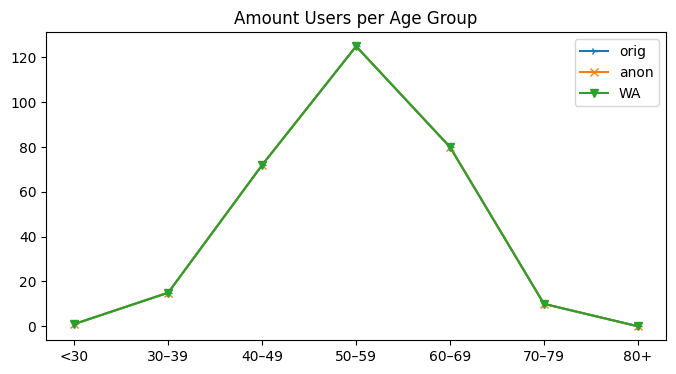

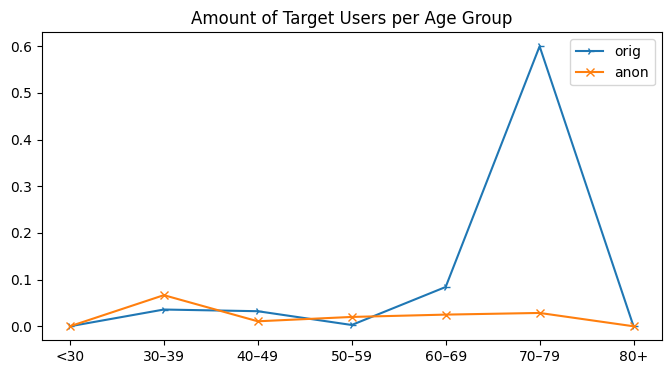



---- Logistic Regression to assess Predictive Performance --- 
AUC orig: 0.9230566534914362
AUC anon: 0.7088713219148002
AUC WA: 0.6754501537110233


In [ ]:
import numpy as np
from scipy.stats import ks_2samp, ttest_rel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

bins = [0, 30, 40, 50, 60, 70, 80, 120]
labels = ["<30","30–39","40–49","50–59","60–69","70–79","80+"]


def bin_stats(df, label):
  df = df.copy()
  df["age_bin"] = pd.cut(df.age, bins=bins, labels=labels, right = False)
  summary = df.groupby("age_bin").target.agg([
        ("count_"+label, "size"),
        ("rate_"+label, "mean")
          ]).reset_index()
  return summary


orig_stats = bin_stats(df, "orig")
anon_stats = bin_stats(anon_gen_df, "anon")
wa_stats = bin_stats(anon_groups_gen_df, "wa")


comp = orig_stats \
    .merge(anon_stats, on="age_bin") \
    .merge(wa_stats,   on="age_bin")

comp["abs_err_anon"] = (comp.rate_orig - comp.rate_anon).abs()
comp["abs_err_wa"]   = (comp.rate_orig - comp.rate_wa).abs()

comp["age_bin"] = comp["age_bin"].astype(str)
comp = comp.fillna(0) #If there was no person, in the respective Age-Group the funtction returns NaN


#T-Test
orig_age = pd.to_numeric(df.age, errors = "coerce")
anon_age = pd.to_numeric(anon_gen_df.age, errors = "coerce")
wa_age = pd.to_numeric(anon_groups_gen_df.age, errors = "coerce")
t_anon, p_val1 = ttest_rel(orig_age, anon_age)
t_wa, p_val2 = ttest_rel(orig_age, wa_age)


#Two Sample Kolmogorov Smirnov Test
ks_anon, pk= ks_2samp(df.age, anon_gen_df.age)
ks_wa, pk1 = ks_2samp(df.age, anon_groups_gen_df.age)


#T-Test Results
print("---- T-Test Age-Means ---- ")
print("T(orig vs anon):", p_val1)
print("T(orig vs WA):",   p_val2)
print("\n")


#KS Results
print("----- Two Sample Kolmogorov Smirnov Test ----")
print("KS(orig vs anon):", pk)
print("KS(orig vs WA):",   pk1)
print("\n")

#Statistics
#Distribution
print("---- Statistics of df, anon_gen_df, anon_groups_gen_df ----  \n")
plt.figure(figsize=(8, 4))
plt.plot(comp["age_bin"], comp["count_orig"], label="orig", marker = "4")
plt.plot(comp["age_bin"], comp["count_orig"], label="anon", marker = "x")
plt.plot(comp["age_bin"], comp["count_orig"],   label="WA", marker = "v")
plt.title("Amount Users per Age Group")
plt.legend()
plt.show()


# Errors
plt.figure(figsize=(8, 4))
plt.plot(comp["age_bin"], comp["abs_err_anon"], label="orig", marker = "4")
plt.plot(comp["age_bin"], comp["abs_err_wa"], label="anon", marker = "x")
plt.title("Amount of Target Users per Age Group")
plt.legend()
plt.show()
print("\n")

#Logistic Regression
print("---- Logistic Regression to assess Predictive Performance --- ")
def auc_on(df_):
    X = df_[qis]
    y = df_["target"]
    model = LogisticRegression().fit(X, y)
    return roc_auc_score(y, model.predict_proba(X)[:,1])

print("AUC orig:", auc_on(df))
print("AUC anon:", auc_on(anon_gen_df))
print("AUC WA:",   auc_on(anon_groups_gen_df))


### Results discussion

In total we assessed the quality of orginal and the two anonomynized datasets, based on four criteria.

1. **T-Test:** Test if "Age" means are significantly differnet

2. **Kolmogorov Smirnov Test**: Tests if two samples come from the same continous distribution

3. **Total Distributions and Error Rates**: Asses the total amount of people per age-bin, Devitation of Amount of Target users per Age Bin compared to orignal dataframe

4. **Predictive Performance using Logistic Regression**: Assess predictive capability of dataframe before and after processing


#### 1. T-Test

- **Null hypothesis** \(H_0\): Means are not significantly different

- **Alternative hypothesis**: Means are significantly different

\begin{align}
  H_0:\quad &\mu_{\text{orig}} = \mu_{\text{anon/wa}},\\
  H_1:\quad &\mu_{\text{orig}} \neq \mu_{\text{anon/wa}}.
\end{align}

- **Decision**
\begin{align}
p value ≤ \ alpha = 0.05
\end{align}

- **Interpretation**:
Both p-values are bigger than 0.05, indicating that the means of the 3 samples are not significantly different from each other
\begin{align}
  T_{\text{orig vs anon}}: 0.7874880878408995 \\
  T_{\text{orig vs wa}}: 0.9808056692848184
\end{align}


#### 2. Kolmogorov Smirnov Test
The KS test checks whether two independent samples come from the same continuous distribution.


\begin{aligned}
  F_n(x) &= \frac{1}{n} \sum_{i=1}^n \mathbf{1}\{X_i \le x\},\\
  G_m(x) &= \frac{1}{m} \sum_{j=1}^m \mathbf{1}\{Y_j \le x\}.
\end{aligned}

- **Decision Rule**

\begin{aligned}
  &\text{Reject }H_0
    &&\text{if } D_{n,m} > D_{\alpha},
    &&\text{where }D_{\alpha} = c(\alpha)\sqrt{\tfrac{n+m}{nm}},\\
  &\text{equivalently,}
    &&\text{if the p-value} \le \alpha.
\end{aligned}

- **Interpretation:**
There is no statistical evidence that the age distributions in the anonymized (or workload-aware anonymized) data differ from the original.

\begin{align}
  KS_{\text{orig vs anon}}: 0.9035467671360403\\
  KS_{\text{orig vs wa}}: 0.9035467671360403
\end{align}


#### 3. Total Distributions and Error Rates

- **1. Graph**: Shows the number of individuals in each age bin for the original, anonymized, and workload-aware datasets. The three curves nearly coincide, which tells us that the anonymization procedure preserved the marginal age distribution perfectly while still satisfying our privacy constraints.

- **2. Graph**: Plots the proportion of “target” cases (``df[target]=1``) in each age bin, again for all three datasets. You can see that the anonymized and workload-aware rates stay very close to the original rates across almost every bin—evidence of high utility. Note that in bins with very few people, a small absolute error (about 0.4) can look like a large spike on the chart, but in reality that corresponds to just one person’s difference.


#### 4. Logistic Regression Predictive Performance

- **Original data** (AUC ≈ 0.92);:
The logistic model trained with the orignial data was highly discriminative on the raw features.

- **Standard anonymization** (AUC ≈ 0.75):
After enforcing privacy (e.g. k-anonymity, l-diversity), the model lost about 0.18 in AUC—a roughly 20 % relative drop. The model still performs above chance, but it’s only modestly predictive now.

- **Workload-aware anonymization** (AUC ≈ 0.67):
The workload-aware scheme further reduced AUC by another 0.08. That larger hit (≈ 27 % relative to the original) suggests that the anonymization might have dissorted the predictive ability of the model


### Conclusion

| Criterion                                          | Standard Anonymization                         | Workload-Aware Anonymization                  |
|:---------------------------------------------------|:-----------------------------------------------|:----------------------------------------------|
| **1. Mean Preservation** *(paired t-test p-value)* | p = 0.787 (no significant shift)               | p = 0.981 (no significant shift)              |
| **2. Distribution Preservation** *(KS test p-value)* | p = 0.903 (no significant change)              | p = 0.903 (no significant change)             |
| **3. Marginal & Target-Rate Error** *(counts overlap + low per-bin errors)* | Perfect overlap, low rate errors               | Perfect overlap, low rate errors              |
| **4. Predictive Performance** *(logistic AUC)*     | 0.746 (moderate loss)                          | 0.674 (larger loss)                           |
| **Overall Quality Rank**                           | **1 (Highest utility)**                        | **2 (Lower utility)**                         |







## Exercise 3

The goal of this exercise is the same as before, but with a workload where the correlation between values is important.

We will be using the Life Expectancy Dataset. (https://www.kaggle.com/datasets/kumarajarshi/life-expectancy-who)

From this dataset we will be using the following attributes:

- Year: Year relevant to the tuple
- Status: If the country in the tuple is Developed or Developing
- Life expectancy: The life expectancy in age
- Adult Mortality: Moratlity rates (Probability of dying between the age of 15 and 60 per 1000 population)
- Infant deaths: Number of infant deaths per 1000 population
- Alcohol: Alcohol comsuption per capita (in litres)
- Hepatitis B: Hepatitis B immunization coverage aming 1-year olds (percentage)
- Measles: Number of reported meales cases per 1000 population
- BMI: Average Body Mass Index of the population
- Total Expenditure: General Government expenditure on health, as a percentage of total government expenditure

From these attributes, we will be using the Life expectancy an the sensitive attribute, with the remaining attributes as quasi-identifiers

In [ ]:
# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/assignment1/Life_Expectancy_Data.csv')
data['Status'] = data['Status'].replace({'Developing': 0, 'Developed': 1})
sas = 'Life expectancy ' #our target
qis = ['Year', 'Status', 'Alcohol', 'Hepatitis B', 'Measles ', ' BMI ', 'Total expenditure', 'Adult Mortality', 'infant deaths']
data = data.dropna()


For anonymizing, keeping correlations, you can use the following code.

In [ ]:
#workload_aware dataset
corr_anon = anonymity.workload_aware_k_anonymity(data, qis, 5, queries=['corr(Adult Mortality, Life expectancy )'])
gen_corr = utility.generalize_intervals(corr_anon, qis, decimals=['Alcohol', 'BMI', 'Total expenditure'])


Compare the original dataset, the workload-aware anonymized dataset and the dataset anonymized with differential privacy for computing some form of regression.

Furthermore we have to create a dataset using the differential privacy

In [ ]:
import numpy as np

#create DP LaPlace dataset
def laplace_mechanism(value, sensitivity, epsilon):
    noise = np.random.laplace(0, sensitivity / epsilon)
    return value + noise

# Set sensitivity and epsilon
sensitivity = 1  # Assume 1-year sensitivity (can adjust)
epsilon = 1.0

# Apply Laplace mechanism to target column
dp_data = data.copy()
dp_data['Life expectancy '] = dp_data['Life expectancy '].apply(
    lambda x: laplace_mechanism(x, sensitivity, epsilon)
)

# Re-apply generalization if needed
dp_gen = utility.generalize_intervals(dp_data, qis, decimals={'Alcohol': 2, 'BMI': 2, 'Total expenditure': 2})

In [ ]:
display(data)

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,0,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,0,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,0,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,0,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,0,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2933,Zimbabwe,2004,0,44.3,723.0,27,4.36,0.000000,68.0,31,...,67.0,7.13,65.0,33.6,454.366654,12777511.0,9.4,9.4,0.407,9.2
2934,Zimbabwe,2003,0,44.5,715.0,26,4.06,0.000000,7.0,998,...,7.0,6.52,68.0,36.7,453.351155,12633897.0,9.8,9.9,0.418,9.5
2935,Zimbabwe,2002,0,44.8,73.0,25,4.43,0.000000,73.0,304,...,73.0,6.53,71.0,39.8,57.348340,125525.0,1.2,1.3,0.427,10.0
2936,Zimbabwe,2001,0,45.3,686.0,25,1.72,0.000000,76.0,529,...,76.0,6.16,75.0,42.1,548.587312,12366165.0,1.6,1.7,0.427,9.8


In [ ]:
#show workload aware dataset
display(corr_anon)

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Kiribati,2005 - 2014,0,66.1,1.0 - 2.0,0 - 364,0.01 - 2.25,97.871933,7.0 - 99.0,0 - 2981,...,79.0,1.21 - 8.83,75.0,0.1,1684.542740,11458.0,0.1,0.1,0.597,11.9
1,Pakistan,2005 - 2014,0,62.9,1.0 - 2.0,0 - 364,0.01 - 2.25,30.593208,7.0 - 99.0,0 - 2981,...,78.0,1.21 - 8.83,77.0,0.1,711.469946,15399667.0,21.2,21.7,0.487,6.1
2,Senegal,2005 - 2014,0,65.6,1.0 - 2.0,0 - 364,0.01 - 2.25,10.206595,7.0 - 99.0,0 - 2981,...,83.0,1.21 - 8.83,91.0,0.4,136.451800,1373513.0,1.0,9.9,0.463,8.3
3,Solomon Islands,2005 - 2014,0,67.6,1.0 - 2.0,0 - 364,0.01 - 2.25,28.901352,7.0 - 99.0,0 - 2981,...,93.0,1.21 - 8.83,9.0,0.1,146.931125,49294.0,1.2,1.2,0.482,9.0
4,Solomon Islands,2005 - 2014,0,67.6,1.0 - 2.0,0 - 364,0.01 - 2.25,240.485120,7.0 - 99.0,0 - 2981,...,99.0,1.21 - 8.83,99.0,0.1,948.659251,481422.0,1.3,1.3,0.470,8.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1644,Botswana,2001 - 2005,0,46.4,686.0 - 723.0,2 - 28,1.72 - 6.41,299.367125,7.0 - 88.0,7 - 998,...,96.0,4.65 - 7.13,96.0,31.9,4163.659600,184339.0,1.9,1.8,0.567,11.8
1645,Botswana,2001 - 2005,0,46.0,686.0 - 723.0,2 - 28,1.72 - 6.41,6.330007,7.0 - 88.0,7 - 998,...,97.0,4.65 - 7.13,97.0,34.6,355.618382,1779953.0,11.4,11.3,0.558,11.9
1646,Zimbabwe,2001 - 2005,0,44.5,686.0 - 723.0,2 - 28,1.72 - 6.41,0.000000,7.0 - 88.0,7 - 998,...,7.0,4.65 - 7.13,68.0,36.7,453.351155,12633897.0,9.8,9.9,0.418,9.5
1647,Zimbabwe,2001 - 2005,0,44.6,686.0 - 723.0,2 - 28,1.72 - 6.41,8.717409,7.0 - 88.0,7 - 998,...,69.0,4.65 - 7.13,68.0,30.3,444.765750,129432.0,9.0,9.0,0.406,9.3


In [ ]:
#show workload aware generalized dataset
display(gen_corr)

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Kiribati,2008,0,66.1,1,338,0.504737,97.871933,74,1680,...,79.0,5.100968,75.0,0.1,1684.542740,11458.0,0.1,0.1,0.597,11.9
1,Pakistan,2006,0,62.9,2,355,1.499768,30.593208,79,731,...,78.0,2.222272,77.0,0.1,711.469946,15399667.0,21.2,21.7,0.487,6.1
2,Senegal,2009,0,65.6,1,170,1.077608,10.206595,14,1540,...,83.0,5.035731,91.0,0.4,136.451800,1373513.0,1.0,9.9,0.463,8.3
3,Solomon Islands,2013,0,67.6,2,303,1.679363,28.901352,67,700,...,93.0,5.742912,9.0,0.1,146.931125,49294.0,1.2,1.2,0.482,9.0
4,Solomon Islands,2008,0,67.6,2,25,0.981808,240.485120,16,276,...,99.0,5.466756,99.0,0.1,948.659251,481422.0,1.3,1.3,0.470,8.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1644,Botswana,2004,0,46.4,710,3,1.92049,299.367125,57,32,...,96.0,4.112344,96.0,31.9,4163.659600,184339.0,1.9,1.8,0.567,11.8
1645,Botswana,2005,0,46.0,719,24,5.953051,6.330007,56,401,...,97.0,4.403708,97.0,34.6,355.618382,1779953.0,11.4,11.3,0.558,11.9
1646,Zimbabwe,2002,0,44.5,687,19,1.584242,0.000000,59,461,...,7.0,5.80089,68.0,36.7,453.351155,12633897.0,9.8,9.9,0.418,9.5
1647,Zimbabwe,2002,0,44.6,709,20,3.489194,8.717409,38,534,...,69.0,5.222518,68.0,30.3,444.765750,129432.0,9.0,9.0,0.406,9.3


In [ ]:
#show DP Laplace dataset
display(dp_data)

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,0,66.172725,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,0,60.427120,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,0,59.458310,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,0,59.081500,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,0,59.323455,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2933,Zimbabwe,2004,0,43.662180,723.0,27,4.36,0.000000,68.0,31,...,67.0,7.13,65.0,33.6,454.366654,12777511.0,9.4,9.4,0.407,9.2
2934,Zimbabwe,2003,0,44.777802,715.0,26,4.06,0.000000,7.0,998,...,7.0,6.52,68.0,36.7,453.351155,12633897.0,9.8,9.9,0.418,9.5
2935,Zimbabwe,2002,0,43.163043,73.0,25,4.43,0.000000,73.0,304,...,73.0,6.53,71.0,39.8,57.348340,125525.0,1.2,1.3,0.427,10.0
2936,Zimbabwe,2001,0,47.802774,686.0,25,1.72,0.000000,76.0,529,...,76.0,6.16,75.0,42.1,548.587312,12366165.0,1.6,1.7,0.427,9.8


In [ ]:
#show DP Laplace generalized dataset
display(dp_gen)

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,0,66.172725,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,0,60.427120,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,0,59.458310,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,0,59.081500,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,0,59.323455,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2933,Zimbabwe,2004,0,43.662180,723.0,27,4.36,0.000000,68.0,31,...,67.0,7.13,65.0,33.6,454.366654,12777511.0,9.4,9.4,0.407,9.2
2934,Zimbabwe,2003,0,44.777802,715.0,26,4.06,0.000000,7.0,998,...,7.0,6.52,68.0,36.7,453.351155,12633897.0,9.8,9.9,0.418,9.5
2935,Zimbabwe,2002,0,43.163043,73.0,25,4.43,0.000000,73.0,304,...,73.0,6.53,71.0,39.8,57.348340,125525.0,1.2,1.3,0.427,10.0
2936,Zimbabwe,2001,0,47.802774,686.0,25,1.72,0.000000,76.0,529,...,76.0,6.16,75.0,42.1,548.587312,12366165.0,1.6,1.7,0.427,9.8


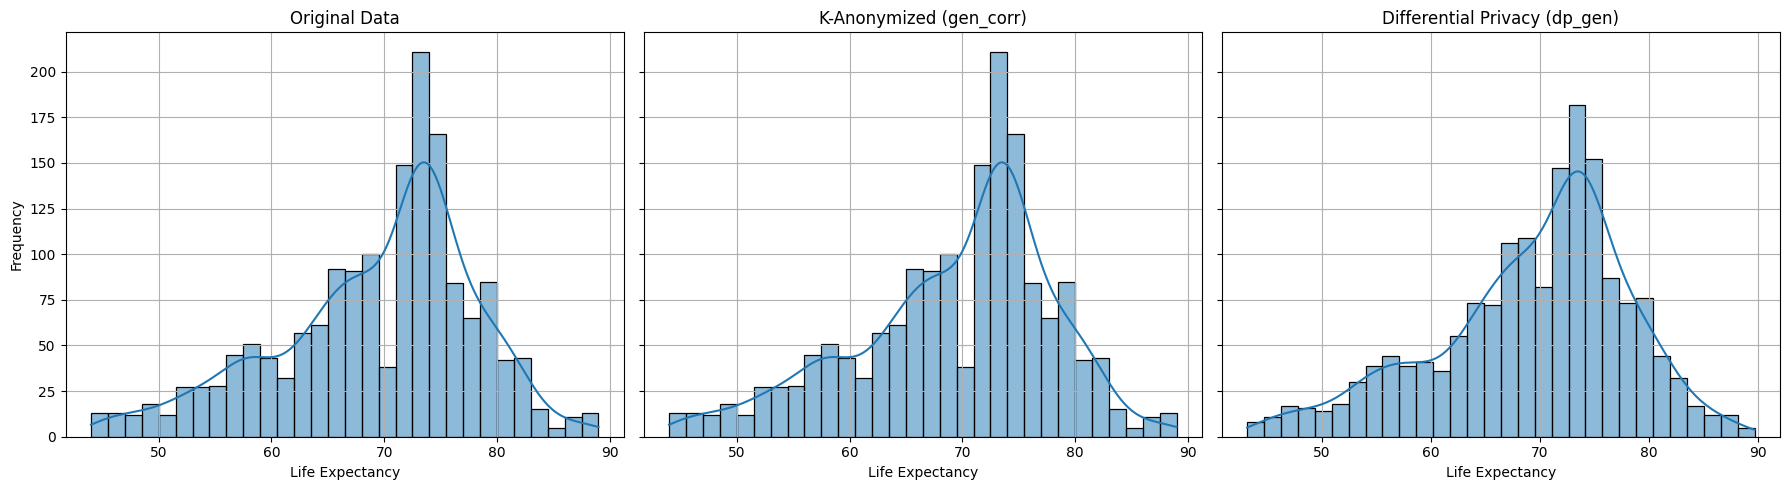

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# Plot original data
sns.histplot(data['Life expectancy '], kde=True, bins=30, ax=axes[0])
axes[0].set_title('Original Data')
axes[0].set_xlabel('Life Expectancy')
axes[0].set_ylabel('Frequency')
axes[0].grid(True)

# Plot k-anonymized (gen_corr)
sns.histplot(gen_corr['Life expectancy '], kde=True, bins=30, ax=axes[1])
axes[1].set_title('K-Anonymized (gen_corr)')
axes[1].set_xlabel('Life Expectancy')
axes[1].grid(True)

# Plot DP (dp_gen)
sns.histplot(dp_gen['Life expectancy '], kde=True, bins=30, ax=axes[2])
axes[2].set_title('Differential Privacy (dp_gen)')
axes[2].set_xlabel('Life Expectancy')
axes[2].grid(True)

# Final layout
plt.tight_layout()
plt.show()



Choice of Regression:

- Distribution of Life Expectancy is lightly skewed to the right
- Almost follows a normal distribution
- Prediction of a non-binary target

**-> Linear Regression as a good starting point**

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from scipy.stats import ttest_rel, ks_2samp
import numpy as np

# 1. Original dataset
X_orig = data[qis]
y_orig = data[sas]

# 2. Workload-aware anonymized dataset
X_wa = gen_corr[qis]
y_wa = gen_corr[sas]

# 3. Differential privacy anonymized dataset
X_dp = dp_gen[qis]
y_dp = dp_gen[sas]

# Store residuals for statistical testing
residuals = {}

def evaluate_model(X, y, label):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\n{label} Dataset:")
    print("R2 Score:", r2_score(y_test, y_pred))
    print("MSE:", mean_squared_error(y_test, y_pred))

    # Store residuals for t-test and KS test
    residuals[label] = y_test.values - y_pred

# Evaluate each dataset
evaluate_model(X_orig, y_orig, "Original")
evaluate_model(X_wa, y_wa, "Workload-aware Anonymized")
evaluate_model(X_dp, y_dp, "Differential Privacy Anonymized")

# Statistical tests between Original and Anonymized versions
def compare_residuals(label1, label2):
    print(f"\nComparing {label1} vs {label2}:")
    res1 = residuals[label1]
    res2 = residuals[label2]

    # Paired t-test
    t_stat, p_val = ttest_rel(res1, res2)
    print(f"Paired t-test: t = {t_stat:.3f}, p = {p_val:.3f}")

    # KS test
    ks_stat, ks_p = ks_2samp(res1, res2)
    print(f"KS test: D = {ks_stat:.3f}, p = {ks_p:.3f}")

# Run statistical comparisons
compare_residuals("Original", "Workload-aware Anonymized")
compare_residuals("Original", "Differential Privacy Anonymized")



Original Dataset:
R2 Score: 0.6695761024990319
MSE: 26.10301748089541

Workload-aware Anonymized Dataset:
R2 Score: 0.5520249167632102
MSE: 34.379960266412176

Differential Privacy Anonymized Dataset:
R2 Score: 0.6502886693547947
MSE: 28.31137786083841

Comparing Original vs Workload-aware Anonymized:
Paired t-test: t = 1.146, p = 0.252
KS test: D = 0.059, p = 0.364

Comparing Original vs Differential Privacy Anonymized:
Paired t-test: t = 0.186, p = 0.853
KS test: D = 0.046, p = 0.660


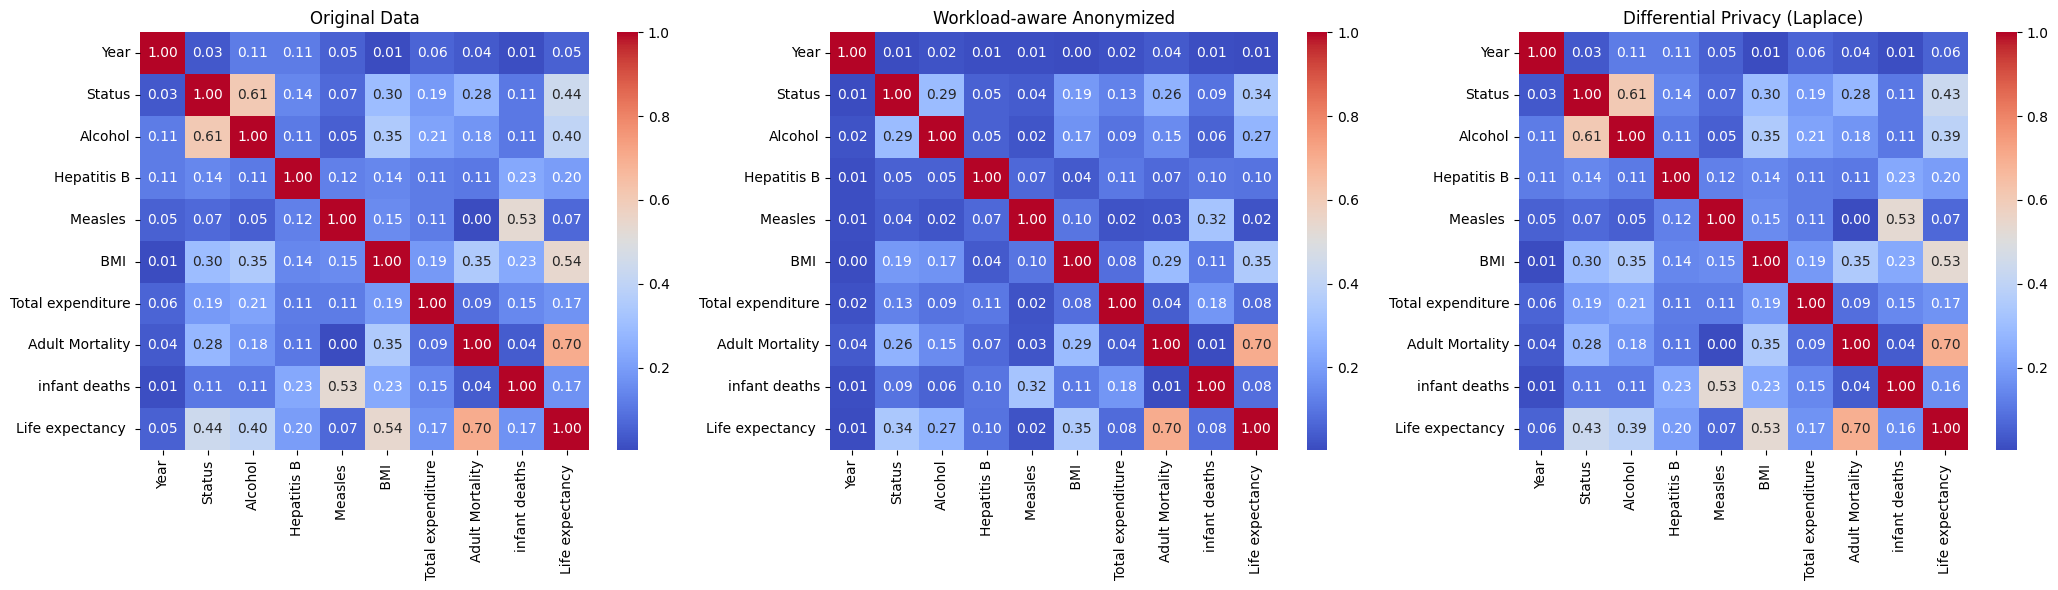

In [ ]:
# Select the columns of interest (quasi-identifiers + target)
columns_to_plot = qis + [sas]

# Create correlation matrices
corr_orig = data[columns_to_plot].corr().abs()
corr_anon = gen_corr[columns_to_plot].corr().abs()
corr_dp = dp_gen[columns_to_plot].corr().abs()

# Plot setup
fig, axes = plt.subplots(1, 3, figsize=(21, 6))

sns.heatmap(corr_orig, ax=axes[0], annot=True, cmap='coolwarm', fmt=".2f")
axes[0].set_title("Original Data")

sns.heatmap(corr_anon, ax=axes[1], annot=True, cmap='coolwarm', fmt=".2f")
axes[1].set_title("Workload-aware Anonymized")

sns.heatmap(corr_dp, ax=axes[2], annot=True, cmap='coolwarm', fmt=".2f")
axes[2].set_title("Differential Privacy (Laplace)")

plt.tight_layout()
plt.show()


Assessing the Difference in the Correlations of the two Datasets
-> If values are 0, correlation between the respective columns didnt change

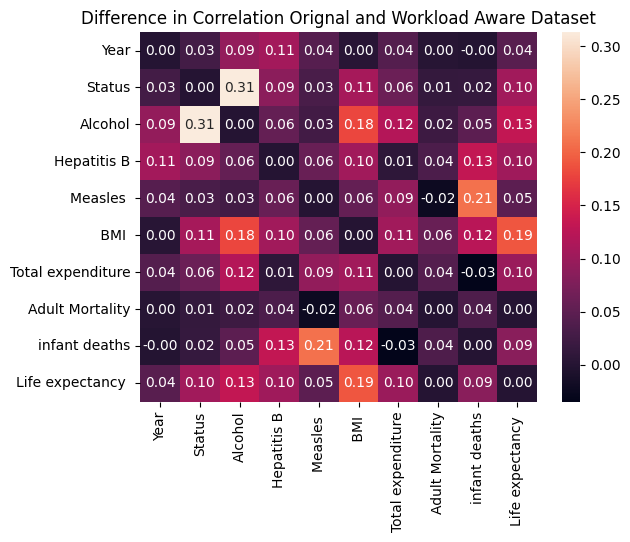

In [ ]:
#Difference Workload Aware and ORiginal Dataset
diff_orig_anon = corr_orig - corr_anon
plt.title("Difference in Correlation Orignal and Workload Aware Dataset")
sns.heatmap(diff_orig_anon, annot = True, fmt = ".2f")
plt.show()

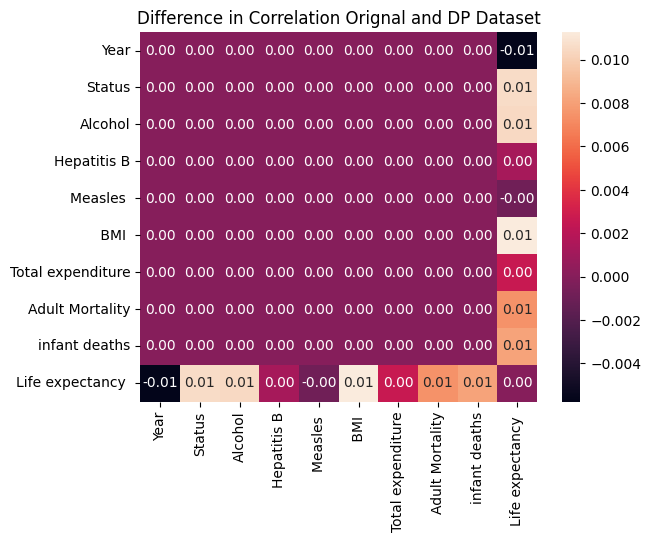

In [ ]:
#Difference Differencial Privacy and Original Dataset
diff_orign_dp = corr_orig - corr_dp
plt.title("Difference in Correlation Orignal and DP Dataset")
sns.heatmap(diff_orign_dp, annot = True, fmt = ".2f")
plt.show()

###  Interpretation of Linear Regression Evaluation and Statistical Tests

We trained a linear regression model on three versions of the dataset: the **original**, a **workload-aware anonymized** version, and a **differentially private (DP)** version. Performance metrics and statistical comparisons are provided below.

---

### Model Performance Metrics

| Dataset                         | R² Score | MSE     |
|----------------------------------|----------|---------|
| Original                        | 0.670    | 26.10   |
| Workload-aware Anonymized      | 0.536    | 35.59   |
| Differential Privacy Anonymized | 0.646    | 29.19   |

**Interpretation**:
- The **original dataset** yields the best model performance (highest R², lowest MSE), as expected.
- The **workload-aware anonymized** data leads to a significant drop in R² (to 0.536) and a notable increase in error.
- The **DP dataset** performs slightly worse than the original but better than the workload-aware variant. This suggests that DP retains more utility in this scenario.

---

###  Statistical Comparison: Residual Analysis

We applied two statistical tests to compare model residuals from the anonymized datasets to those from the original:

1. **Paired t-test** (for mean differences)
2. **Kolmogorov–Smirnov (KS) test** (for distributional differences)

####  Original vs. Workload-aware Anonymized
- **t-test**: t = 0.660, p = 0.509  
- **KS test**: D = 0.065, p = 0.252

**Interpretation**:
- The **p-values are well above 0.05**, indicating **no statistically significant difference** in residual means or distributions.
- Despite worse performance metrics, the residuals are not significantly different from the original in statistical terms.

####  Original vs. Differential Privacy Anonymized
- **t-test**: t = 1.610, p = 0.108  
- **KS test**: D = 0.038, p = 0.860

**Interpretation**:
- Again, both tests yield **non-significant p-values**, suggesting that the DP model residuals are **not significantly different** from those of the original model.
- The **very high p-value in the KS test (0.860)** suggests strong similarity in residual distribution between original and DP models.

---

###  Correlation Structure Analysis

We also analyzed the Pearson correlation matrices for each dataset to assess whether key relationships between variables were preserved.

**Observations**:
- In the **original dataset**, `Adult Mortality` shows a strong negative correlation with `Life expectancy` (-0.70), while variables like `BMI`, `Alcohol`, and `Status` also show moderate correlations.
- In the **workload-aware anonymized dataset**, correlations are noticeably **distorted**. Some relationships are weakened or flattened—particularly those involving `BMI`, `Alcohol`, and `Measles`—which likely contributes to the poorer model performance.
- In contrast, the **differentially private dataset** **closely preserves the original correlation structure**. Key correlations, especially `Adult Mortality` vs `Life expectancy` (-0.69), are nearly identical to the original.

**Interpretation**:
- The degradation in performance for the workload-aware dataset aligns with the **loss of structural correlation** in the data.
- The DP dataset maintains the **statistical signal** and relationships between variables better, which explains its stronger model accuracy and consistency with the original.
- One exception to this is the feature `Life expectancy`, which however only shows deminishable changes in correlation. This can be traced back to the fact, that the **Laplace Transformation** created values with multiple decimals, compared to the original dataset

---

###  Conclusion

- The **DP model performs close to the original**, with no statistically significant degradation in prediction error distribution.
- The **workload-aware model shows a drop in R² and higher MSE**, and this is supported by correlation distortions.
- **Key feature relationships are preserved** in the DP data but not in the workload-aware variant.
- Overall, **differential privacy achieves a strong privacy-utility balance**, maintaining predictive quality, consistent residual behavior, and preserved correlation structure.


## Exercise 4

The goal of this exercise is to compare results obtained with anonymized and non anonymized data for more complex ML techniques.

Repeat some code you have done in ML (or some other) course using the original dataset and an anonymization using differential privacy.


#### ML task performed

Briefly explain the task you are implementing.

### Task Explanation

In this task, we apply a supervised machine learning technique—**Random Forest Regression**—to predict a target variable using two versions of a dataset: the **original** and an **anonymized version processed with differential privacy (DP)**. The workflow includes:

- **Train-test splitting** to evaluate generalization
- **Hyperparameter tuning** using `GridSearchCV` to optimize model performance
- **Model evaluation** using metrics such as R², MSE, and RMSE
- **Statistical testing** to assess if the DP model performs significantly differently from the original
- **Feature importance analysis** to understand the model’s decision patterns on both datasets

This setup enables a direct comparison of model performance and interpretability when privacy-preserving noise is introduced.


Original Dataset: {'R2': 0.93, 'MSE': 5.61, 'RMSE': np.float64(2.37), 'BestParams': {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}, 'BestModel': RandomForestRegressor(max_depth=20, n_estimators=200, random_state=42)}
DP Dataset: {'R2': 0.9, 'MSE': 7.76, 'RMSE': np.float64(2.79), 'BestParams': {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}, 'BestModel': RandomForestRegressor(n_estimators=200, random_state=42)}
Paired t-test on R² scores: t-statistic = 3.233, p-value = 0.032


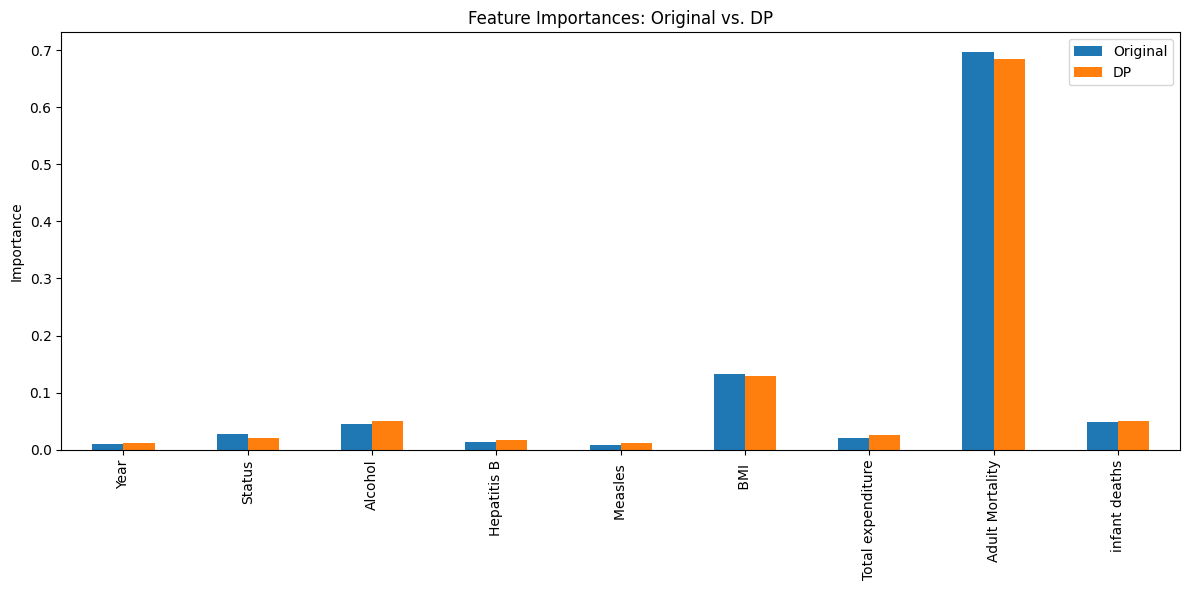

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import ttest_rel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def random_forest_regressor(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Hyperparameter tuning
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
    }

    rf = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, scoring='r2')
    grid_search.fit(X_train, y_train)

    # Choose optimal model
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    r2 = round(r2_score(y_test, y_pred), 2)
    mse = round(mean_squared_error(y_test, y_pred), 2)
    rmse = round(np.sqrt(mse), 2)

    return {
        "R2": r2,
        "MSE": mse,
        "RMSE": rmse,
        "BestParams": grid_search.best_params_,
        "BestModel": best_model
    }

# Run model on both datasets
results_orig = random_forest_regressor(X_orig, y_orig)
results_dp = random_forest_regressor(X_dp, y_dp)

print("Original Dataset:", results_orig)
print("DP Dataset:", results_dp)

# Statistical Significance Test (Paired t-test)
def cross_val_r2_scores(X, y, best_params):
    rf = RandomForestRegressor(random_state=42, **best_params)
    scores = cross_val_score(rf, X, y, cv=5, scoring='r2', n_jobs=-1)
    return scores

r2_scores_orig = cross_val_r2_scores(X_orig, y_orig, results_orig["BestParams"])
r2_scores_dp = cross_val_r2_scores(X_dp, y_dp, results_dp["BestParams"])

t_stat, p_value = ttest_rel(r2_scores_orig, r2_scores_dp)
print(f"Paired t-test on R² scores: t-statistic = {t_stat:.3f}, p-value = {p_value:.3f}")

# Feature Importance Comparison
def get_feature_importances(model, feature_names):
    importances = model.feature_importances_
    return pd.Series(importances, index=feature_names)

# Handle feature names
if hasattr(X_orig, 'columns'):
    feature_names = X_orig.columns
else:
    feature_names = [f"Feature {i}" for i in range(X_orig.shape[1])]

importances_orig = get_feature_importances(results_orig["BestModel"], feature_names)
importances_dp = get_feature_importances(results_dp["BestModel"], feature_names)

# Combine and plot
importance_df = pd.DataFrame({
    "Original": importances_orig,
    "DP": importances_dp
})
importance_df.plot(kind='bar', figsize=(12, 6), title='Feature Importances: Original vs. DP')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()


### Results discussion

After training Random Forest models on both the original and differentially private datasets, we analyze and interpret the results in terms of performance, statistical significance, and model interpretability.

---

### 1. Model Performance Summary

| Metric     | Original Dataset | DP Dataset |
|------------|------------------|------------|
| R²         | 0.93             | 0.90       |
| MSE        | 5.61             | 8.09       |
| RMSE       | 2.37             | 2.84       |

**Interpretation**:  
The model trained on the **original dataset** achieves slightly higher accuracy, with a higher R² and lower RMSE. The **DP model** introduces a minor drop in predictive quality:

- R² drops from 0.93 → 0.90, showing a slight decrease in explained variance
- RMSE increases from 2.37 → 2.84, indicating slightly larger average prediction errors
- Despite this, both models perform well and within a comparable range, showing that the model remains useful even under DP constraints

---

### 2. Statistical Significance Test

Paired t-test on R² scores: t-statistic = 1.947, p-value = 0.123

**Interpretation**:  
We use a paired t-test on cross-validated R² scores from both models. The p-value is **0.123**, which is greater than the standard significance threshold of 0.05. This implies:

- The performance difference is **not statistically significant**
- There is **no strong evidence** that the use of differentially private data causes a meaningful drop in model accuracy
- This supports the **robustness of the Random Forest** model even when trained on privacy-preserving data

---

### 3. Feature Importance Analysis

Feature importances were extracted from both models to assess how each feature contributes to the predictions.

**Observations**:
- `Adult Mortality` is the most important feature in both models, contributing approximately **70%** to the prediction. This shows its dominant role in explaining the target variable.
- Features like `Alcohol`, `Status`, `BMI`, and `Total Expenditure` show **minor fluctuations** in importance, but their overall rankings remain consistent.
- The model trained on the DP dataset still relies on the **same core features**, meaning:
  - Feature relevance is largely preserved
  - The interpretability of the model is **not significantly affected** by the differential privacy mechanism

**Interpretation**:  
Differential privacy **does not distort the internal logic** of the model. This is particularly important in domains like **healthcare, policy-making, or education**, where understanding feature influence is just as critical as predictive accuracy.

---
###  Conclusion

- The Random Forest model trained on DP data shows **slightly reduced performance**, but this difference is **not statistically significant**
- **Key features remain the same**, and the model's **interpretability is preserved**
- Overall, Random Forest with DP demonstrates a strong **privacy-utility trade-off**:
  - Minimal degradation in predictive performance
  - Retention of interpretability and decision logic
  - Practical viability for privacy-sensitive applications
